# Coding Temple's Data Analytics Full-Time Program
---
## Python for Data Analysis: Machine Learning in Python using Scikit-Learn

### Part 1: Imports

To work with the `scikit-learn` library, we will need to pip install it in our local machine. We will also want to pip install another couple of libraries called: `category encoders` and `xgboost`.

While sklearn has built-in functionality for encoders such as OHE and OrdinalEncoder, the output of these encoders are different than that of the `category encoders` library. We will work with both libraries in conjunction together to make a pipeline object.

The library `xgboost` will allow us access to our boosted models for both Regression and Classification. We will cover over boosting and other ensemble methods later in this lecture.

In [3]:
!python -m pip install scikit-learn
!python -m pip install category_encoders
!python -m pip install xgboost


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Now, when it comes to the actual imports of each item we are going to use today, we will be accessing many different parts of the sklearn library. To see all the available parts of sklearn, check out this [documentation](https://scikit-learn.org/stable/auto_examples/index.html)

In [4]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Part 2: EDA
In this part, we will focus on reading in the data and performing our exploratory data analysis of the dataset.
Our overall goal is to be able to predict the price of a house based off the features given to us in this dataset

In [6]:
# Read in the data using pandas
df = pd.read_csv(r'C:\Users\nargi\Documents\coding temple\data\house prices.csv')

# View the dataset
df.head()


,house_id,neighborhood,area,bedrooms,bathrooms,style,price
0,1112,B,1188,3,2,ranch,598291
1,491,B,3512,5,3,victorian,1744259
2,5952,B,1134,3,2,ranch,571669
3,3525,A,1940,4,2,ranch,493675
4,5108,B,2208,6,4,victorian,1101539


What needs to be done to this dataset?

* Are all columns the data type they need to be?
* Count of null values
* Visualization of the target variable

In [ ]:
# Are all the columns the proper type and how many null values are we dealing with?
df.info()

So we can see that we have 0 null values present within this dataset. Each feature in our dataset is the appropriate data-type as well. There is no cleaning that needs to be done to this data before we begin working with it. Let's double-check our distribution of the target variable as well as a scatterplot of it against each feature.

In [ ]:
# Let's graph out a histogram of our target variable
plt.hist('price', data=df);
plt.xlabel('Price by Hundred-Thousand');
plt.ylabel('Frequency');

What do we notice about the distribution of our target variable? 

How does the skewness of the target affect a model's ability to make predictions?

In [ ]:
# Now, let's visualize the relationship between our target and the rest of our features
sns.pairplot(df, y_vars=['price'])

What do we notice about the relationships between each of these variables and the price column?

### In-Class Exercise 1: Try it out
For this exercise, you will download the data from [Kaggle](https://www.kaggle.com/datasets/rajkumarpandey02/vehicle-fuel-economy-data-us). Once downloaded, your goal will be to:

* Load in the data using Pandas
* Clean the data (check the data-types for inconsistencies, check for null values, change column names if needed)
* Identify and create a visualization of what you believe the target should be
* Create a pairplot of the target to the rest of your features present within the dataset.

In [ ]:
# YOUR CODE HERE


### Part 3: Separating the target and splitting the data

When working with a machine learning model, it is important to understand how to present the data to that model in order to make an accurate prediction. To start with, there are two things we need to accomplish before moving forward:

1. We must remove the target vector from the feature matrix. If we leave in the answers to the test before giving it to the model, it cheats and can get a perfect score on the training, but perform terribly outside of the training environment and on any new data. This is also known as data leakage, which is a cause of what we call an overfit model. 

2. We must also split the data apart into a training and testing set. In order to test the effectiveness of a model, we will typically hold back some of our data in order to test how the model will perform when faced with data it has never seen before. The amount of this split is typically 80/20; 80% of the data goes into the training dataset, while the reserved 20% is used as a testing set! We want to include as much data as possible in the training set so our model can draw the best conclusions it can about the target and create more accurate predictions. This will also aid you in finding any overfitting issues your model may be having.

In [ ]:
# Step 1: Identify the target vector
target = 'price'

# Step 2: Separate the target vector from the feature matrix
X = df.drop(columns=target)
y = df[target]

# Step 3: Split the data into a training and testing set, using sklearn
x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=.8, random_state=42)

# View our testing data
display(x_test)
print(y_test)

# Assert statement to double-check our work:
assert len(x_train) + len(x_test) == len(X), 'You did not separate the data properly'

### Part 4: Establish a baseline

A `baseline` is nothing more than a way to check our model's performance. It is the simplest prediction we can make about the data. 

For regression analysis, this baseline is the mean of our target vector. This would be the same as always predicting the average value for each price data-point in the target.

For classification analysis, the baseline is the majority class and the percentage that it occurs becomes your baseline value!

In [ ]:
# Establish a baseline:
baseline = [df.price.mean()] * len(df)
baseline

Using only the average value, we would predict $754,207.88 as the price for each datapoint.

### Part 5: Model Building


For this lecture, we will be walking through multiple models and some new concepts. It can be a lot to absorb all at once, so here is some explanations:

In order to place the data into a model, we will need to preprocess the data. This preprocessing step usually involves two pieces:

1. **An Encoder**: In order to work with string-type data, we need to change the data to a format our model can understand. In this lecture, we will focus on two different types of encoders;
    
    i. **OneHotEncoder**: OneHotEncoding, or also known as OHE, transforms a string column into multiple columns. These columns are labeled with each unique value in the dataset and is a boolean data-type. Each value in each column corresponds to whether that value was present within the original column in that row(1) or not(0). This can be useful for a dataset with only one or two string columns and only a few unique values present in them. OHE does run into a dimensionality issue when you begin to plug in variables with high cardinality(a lot of unique values) or a lot of different string columns. 

    ii. **OrdinalEncoder**: Ordinal Encoding changes the actual values themselves into a numeric representation of the string present within the column. This solves any issues regarding high cardinality, but can result in the loss of some information between the model and the data.
    
Overall, it is important to choose the right encoder for the job in order to provide your model with the best chance at making it's predictions!

2. **An Imputer**: A lot of models don't know how to handle missing values, and missing values can also lead to bias in the model if it does accept them. To circumvent this, we use an imputer. An imputer will infer information about a column, such as the basic statitstics of the column, and fill the missing values based on the method specified. When left blank, the method will default to the mean of the column! We will utilize the `SimpleImputer` module of `sklearn` to accomplish this today. As our current dataset does not have any null values, we will not include one in our pipeline. We will see the use of this later on in this notebook!

Now that we understand the preprocessing of our data, we can begin building our model! Here are the steps we will need to take:

1. We will be creating a pipeline object that combines all of our steps together into a singular object. This will save us a lot of work and time. In order to do so, we will access the `make_pipeline` module of `sklearn`.

2. Inside the pipeline object, we will instantiate all preprocessors and the model!

3. After creation, we will need to fit the model to our training data. **DO NOT FIT THE MODEL TO TESTING DATA!!!**

First, let's take a look at all the steps we would need to go through in order to create a model without a pipeline object and the formula that is behind our Linear Regression model we will be using:

![](https://editor.analyticsvidhya.com/uploads/375512.jpg)

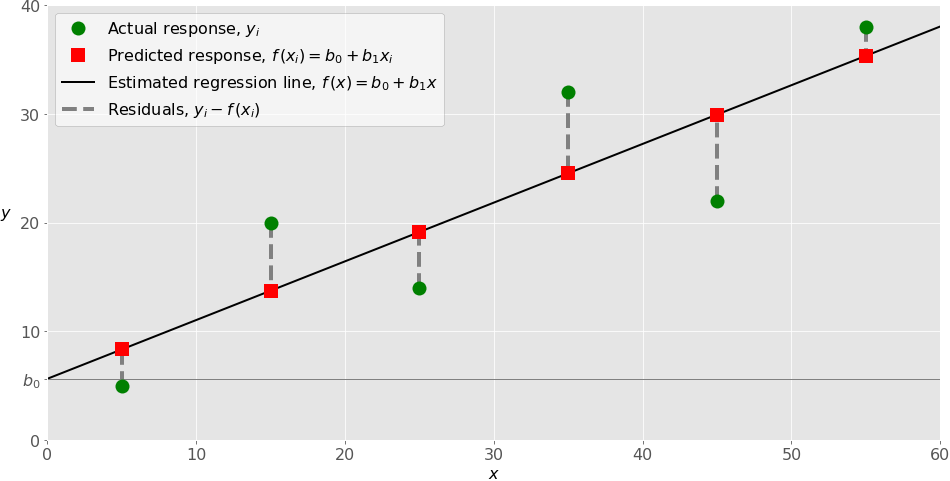

<p><strong>Intercept (<em>b</em><sub>0</sub>)</strong> - Expected value of response variable (y) when explanatory variable (x) is 0</p>
<p><strong>Slope (<em>b</em><sub>1</sub>)</strong> - Expected value of response variable (y) when explanatory variable (x) is 0</p>
<p><strong>Best fit - <em>y</em> = <em>b</em><sub>0</sub> + <em>b</em><sub>1</sub><em>x</em></strong></p>

In [ ]:
# Step 1: Instantiate our Encoder
ohe = OneHotEncoder(use_cat_names=True)

# Step 2: Fit the Encoder
ohe.fit(x_train, y_train)

# Step 3: Transform our data
x_trans = ohe.transform(x_train)

# Step 4: Instantiate the model object
model_dt = LinearRegression()

# Step 5: Fit the model object
model_dt.fit(x_trans, y_train)

Now, let's look at how much easier our make_pipeline function makes this for us

In [ ]:
# Step 1a: Create the pipeline object
model_lr = make_pipeline(
    # Step 1b: Add in any preprocessors to the pipeline
    OneHotEncoder(use_cat_names=True),
    # Step 1c: Add in the model object to the pipeline
    LinearRegression()
)

# Step 2: Fit the pipeline
model_lr.fit(x_train, y_train)

Now that we have fit a single model, let's take a look at other models we could use for this task and compare how each of them performs:

![](https://www.saedsayad.com/images/Decision_tree_r1.png)

In [ ]:
# Step 1a: Create the pipeline object
pipe_dt = make_pipeline(
    # Step 1b: Add in any preprocessors to the pipeline
    OneHotEncoder(use_cat_names=True),
    # Step 1c: Add in the model object to the pipeline
    DecisionTreeRegressor(random_state=42)
)

# Step 2: Fit the pipeline
pipe_dt.fit(x_train, y_train)

![](https://miro.medium.com/v2/resize:fit:1400/1*ZFuMI_HrI3jt2Wlay73IUQ.png)

In [ ]:
# Step 1a: Create the pipeline object
model_rf = make_pipeline(
    # Step 1b: Add in any preprocessors to the pipeline
    OneHotEncoder(use_cat_names=True),
    # Step 1c: Add in the model object to the pipeline
    RandomForestRegressor(random_state=42)
)

# Step 2: Fit the pipeline
model_rf.fit(x_train, y_train)

![](https://docs.aws.amazon.com/images/sagemaker/latest/dg/images/xgboost_illustration.png)

In [ ]:
# Step 1a: Create the pipeline object
model_xg = make_pipeline(
    # Step 1b: Add in any preprocessors to the pipeline
    OneHotEncoder(use_cat_names=True),
    # Step 1c: Add in the model object to the pipeline
    XGBRegressor(random_state=42)
)

# Step 2: Fit the pipeline
model_xg.fit(x_train, y_train)

### In-Class Exercise #2: Build your own models

For this in-class exercise, you will use the dataset you cleaned in the previous task to create 4 different model objects. Remember that you will need to split the data BEFORE creating/fitting each model. For one of the model objects, create it outside of a pipeline with all necessary preprocessors. For the rest, create a pipeline object with all necessary preprocessors and the model object inside of it!

In [ ]:
# YOUR CODE HERE

In [ ]:
# MODEL 1 HERE

In [ ]:
# MODEL 2 HERE

In [ ]:
# MODEL 3 HERE

In [ ]:
# MODEL 4 HERE

### Part 6: Check Metrics

So we built out all these models and fit them to the datasets. Now what? Well, we need to check on the accuracy of these models and compare each to our baseline model to see if it is performing better or worse than the baseline! To do so, we will utilize a few different modules. Note that the measurements of accuracy differ between a Regression analysis and a Classification analysis. In regression, we will use:

* **mean absolute error(MAE)**: Calculated using the actual and predicted values. This measures the residuals of the model's predictions from the actual values and returns the mean value of those residuals

* **mean squared error(MSE)**:Along the same lines as MAE, however, MSE squares the predicted and actual value before subtraction and division, causing errors to be very obvious. MSE can show large numbers due to the amount of variance actually present within the model.

* **r2 score**: Overall assessment of model accuracy. The values range from 0 to 1, indicating a percentage of data that the model is correctly predicting.

Remember that there is no one sure-fire way to check a model's accuracy. The culmination of all these should be what affects our decision on a model, not the value of a singular metric!

In [ ]:
print('Decision Tree Scores:')
print(mean_absolute_error(y_train, pipe_dt.predict(x_train)))
print(mean_absolute_error(y_test, pipe_dt.predict(x_test)))
print('------------------------------')
print('Linear Model Score:')
print(mean_absolute_error(y_train, model_lr.predict(x_train)))
print(mean_absolute_error(y_test, model_lr.predict(x_test)))
print('---------------------------------------')
print('Random Forest Score:')
print(mean_absolute_error(y_train, model_rf.predict(x_train)))
print(mean_absolute_error(y_test, model_rf.predict(x_test)))
print('---------------------------------------')
print('XGBoost Score:')
print(mean_absolute_error(y_train, model_xg.predict(x_train)))
print(mean_absolute_error(y_test, model_xg.predict(x_test)))

In [ ]:
print('Decision Tree Scores:')
print(mean_squared_error(y_train, pipe_dt.predict(x_train)))
print(mean_squared_error(y_test, pipe_dt.predict(x_test)))
print('------------------------------')
print('Linear Model Score:')
print(mean_squared_error(y_train, model_lr.predict(x_train)))
print(mean_squared_error(y_test, model_lr.predict(x_test)))
print('---------------------------------------')
print('Random Forest Score:')
print(mean_squared_error(y_train, model_rf.predict(x_train)))
print(mean_squared_error(y_test, model_rf.predict(x_test)))
print('---------------------------------------')
print('XGBoost Score:')
print(mean_squared_error(y_train, model_xg.predict(x_train)))
print(mean_squared_error(y_test, model_xg.predict(x_test)))

In [ ]:
print('Decision Tree Scores:')
print(r2_score(y_train, pipe_dt.predict(x_train)))
print(r2_score(y_test, pipe_dt.predict(x_test)))
print('------------------------------')
print('Linear Model Score:')
print(r2_score(y_train, model_lr.predict(x_train)))
print(r2_score(y_test, model_lr.predict(x_test)))
print('---------------------------------------')
print('Random Forest Score:')
print(r2_score(y_train, model_rf.predict(x_train)))
print(r2_score(y_test, model_rf.predict(x_test)))
print('---------------------------------------')
print('XGBoost Score:')
print(r2_score(y_train, model_xg.predict(x_train)))
print(r2_score(y_test, model_xg.predict(x_test)))

### Step 7: Tuning a model

After we determine which model we want to use and will best fit our situation, we will want to tune the hyperparameters of that model. Hyperparameters refer to the parameters, or arguments, that each model takes. Each model has different parameters that can be tuned and each one has a level of significance to the final outcome of a model's prediction! Now, we could do this all by hand and input each of these values separately in the model, fit it, then check the metrics. However, there is an easier way to accomplish this task! By using the `RandomizedSearchCV` module, we will be able to parse over a parameter grid, or a dictionary where the key is the parameter and the value is all possible values you want to test the parameter at!

Today, we will be looking over a few of these hyperparameters for the `RandomForestRegressor` model.

In [ ]:
# Step 1: Create a parameter grid
param_grid = {
    'randomforestregressor__n_estimators': range(200,400, 10),
    'randomforestregressor__max_depth' : range(10,110, 10),
    'randomforestregressor__min_samples_split' : [2,5,10],
    'randomforestregressor__min_samples_leaf' : [1,2,5]
}

# Step 2: Instantiate the RSCV module with the model object and the param_grid object
clf = RandomizedSearchCV(model_rf, param_grid)

# Step 3: Fit the data
clf.fit(x_train, y_train)

So now that we have this object, what can we do with it? We can pull the best parameters and best score from the object! Once we have this information, we can easily change these values during the instantiation of our model object and verify using our MSE and R2 score:

In [ ]:
# Grab the best parameters for the model
clf.best_params_

In [ ]:
# Grab the best score the model could come up with
clf.best_score_

### In-Class Exercise 3: 
For this exercise, your goal is to check the metrics of each of your model objects created in the last exercise. After you have identified the model you believe to work the best with the data, you will use the `RandomizedSearchCV` module to parse over a parameter grid and hypertune your model!

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

## Section 2: Classification Analysis

In [ ]:
df_class = pd.read_csv(r'C:\Users\Alex Lucchesi\coding-temple\coding_temple_data_analytics_ft\week-3\data\iris.csv')
df_class.head()

### Part 1: Clean the data/EDA
We will start off with tidying our data and completing our Exploratory Data Analysis

* Are all columns the proper data-type?
* What is the distribution of our target vector?
* Are all the column names following proper conventions?

In [ ]:
# Let's start off with the column names:
print(df_class.columns)

# One method: removes the row that was in the column names though
df_class.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
display(df_class.head())

# Another method which doesn't cause us to lose any info:
df_class = pd.read_csv(r'C:\Users\Alex Lucchesi\coding-temple\coding_temple_data_analytics_ft\week-3\data\iris.csv',
                       names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])

display(df_class.head())

In [ ]:
# Now, let's check the data types and null-counts:
df_class.info()

Looks like each of our columns are the proper types and we have changed each column name to follow proper conventions! Next, let's create some visualizations

In [ ]:
# Visualize the target
sns.histplot(data=df_class, x='species');

Looks like we have a completely even distribution of values between the three unique values of our `species` column, or our target vector!

In [ ]:
sns.pairplot(data = df_class, y_vars='species');

We have some outliers in the sepal length and width, however, most of our data is distributed/clustered together.

### Part 2: Split the data

In [ ]:
# Identify target vector
target = 'species'

# Separate target vector from feature matrix
X = df_class.drop(columns=target)
y = df_class[target]

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

# Assert statement to check split
assert len(x_train) + len(x_test) == len(X), 'Data did not properly split'

### Part 3: Establish a baseline

Remember from our above example how we establish the baseline for a classification problem. Instead of using the mean like we do in regression, we take the majority class from our target vector instead. We will take the value of this as a percentage.

In [ ]:
# Create a baseline using value_counts and max
cl_base = round(max(df_class.species.value_counts(normalize=True)) *100,2)
print(f'Our baseline model can predict our majority class, Iris-setosa, {cl_base}% of the time!')

### Part 4: Model Building

Now we can build our models! The key to remember here is that we are building models for a classification task. Because of this, we will want to ensure that we only use the classification versions of our models!

In [ ]:
# Logistic Regression Pipeline:
lr_pipe = make_pipeline(
    SimpleImputer(),
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(random_state=42)
)

# Fit the pipeline
lr_pipe.fit(x_train, y_train)

In [ ]:
# Decision Tree Pipeline:
dt_pipe = make_pipeline(
    SimpleImputer(),
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42)
)

# Fit the pipeline
dt_pipe.fit(x_train, y_train)

In [ ]:
# Random Forest Pipeline:
rf_pipe = make_pipeline(
    SimpleImputer(),
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42)
)

# Fit the pipeline
rf_pipe.fit(x_train, y_train)

In [ ]:
# XGBoost Pipeline:
xg_pipe = make_pipeline(
    SimpleImputer(),
    OrdinalEncoder(),
    XGBClassifier(objective='binary:logistic')
)

# Fit the pipeline
xg_pipe.fit(x_train,LabelEncoder().fit_transform(y_train))

### Part 5: Evaluate and Check Metrics

In [ ]:
print('Logistic Regression:')
print(f'Training Accuracy: {round(lr_pipe.score(x_train, y_train),2)*100}')
print(f'Testing Accuracy: {round(lr_pipe.score(x_test, y_test),2)*100}')
print('--------------------------')
print('Decision Tree Classifier:')
print(f'Training Accuracy: {round(dt_pipe.score(x_train, y_train), 2)*100}')
print(f'Testing Accuracy: {round(dt_pipe.score(x_test, y_test), 2)*100}')
print('--------------------------')
print('Random Forest Classifier:')
print(f'Training Accuracy: {round(rf_pipe.score(x_train, y_train), 2)*100}')
print(f'Testing Accuracy: {round(rf_pipe.score(x_test, y_test), 2) * 100}')
print('--------------------------')
print('XGBoost Classifier:')
print(f'Training Accuracy: {round(xg_pipe.score(x_train, y_train), 2)*100}')
print(f'Testing Accuracy: {round(xg_pipe.score(x_test, y_test), 2) * 100}')

In [ ]:
print("Logistic Regression:")
print(f"Training ROC AUC Score: {round(roc_auc_score(y_train, lr_pipe.predict_proba(x_train), multi_class='ovr'),2)*100}")
print(f'Testing ROC AUC Score: {round(roc_auc_score(y_test, lr_pipe.predict_proba(x_test), multi_class="ovr"),2)*100}')
print('------------------------------------')
print('Decision Tree Classifier:')
print(f"Training ROC AUC Score: {round(roc_auc_score(y_train, dt_pipe.predict_proba(x_train), multi_class='ovr'),2)*100}")
print(f'Testing ROC AUC Score: {round(roc_auc_score(y_test, dt_pipe.predict_proba(x_test), multi_class="ovr"),2)*100}')
print('------------------------------------')
print('Random Forest Classifier:')
print(f"Training ROC AUC Score: {round(roc_auc_score(y_train, rf_pipe.predict_proba(x_train), multi_class='ovr'),2)*100}")
print(f'Testing ROC AUC Score: {round(roc_auc_score(y_test, rf_pipe.predict_proba(x_test), multi_class="ovr"),2)*100}')
print('------------------------------------')
print('XGBoost Classifier:')
print(f"Training ROC AUC Score: {round(roc_auc_score(y_train, xg_pipe.predict_proba(x_train), multi_class='ovr'),2)*100}")
print(f'Testing ROC AUC Score: {round(roc_auc_score(y_test, xg_pipe.predict_proba(x_test), multi_class="ovr"),2)*100}')
print('------------------------------------')

### Part 6: Communicate Results

From our metrics above, we will be choosing the Logistic Regression model to explore the results of. Let's visualize the feature importances of our model:

In [ ]:
# Create your horizontal barchart here.
coefficients = lr_pipe.named_steps['logisticregression'].coef_
features = lr_pipe.feature_names_in_
print(features)
print(coefficients)
# Coeff sliced for first value in array.
feat_imp = pd.Series(coefficients[0], index=features).sort_values(key=abs)
feat_imp.tail(20).plot(kind='barh')
plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Logistic Regression');

### Part 7: Tune the Model

In [ ]:
import numpy as np
param_grid = {
    'logisticregression__C': np.arange(0.1, 2.0, .2),
    # 'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
}
clf = RandomizedSearchCV(lr_pipe, param_grid)
clf.fit(x_train, y_train)

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_